#ExtremeHelp.ipynb
## ExtremeHelp: Modelo de Visão Computacional para Identificação de Desastres

**Introdução:**
Este notebook demonstra um modelo de classificação de imagens para identificar cenários de desastres (ex: enchente, incêndio, normal) como parte do projeto ExtremeHelp. O objetivo é analisar imagens para auxiliar na identificação e classificação de áreas afetadas, fornecendo informações que podem ser usadas para alertas e otimização de ajuda no aplicativo.

**Passos do Notebook:**
1.  Configuração do Ambiente e Importações Essenciais
2.  Definição de Parâmetros e Caminhos para o Dataset
3.  Preparação dos Geradores de Dados (ImageDataGenerator)
4.  Visualização de Amostras de Imagens (Opcional)
5.  Construção do Modelo de Rede Neural Convolucional (CNN)
6.  Compilação e Treinamento do Modelo
7.  Avaliação do Desempenho do Modelo
8.  Teste do Modelo com Novas Imagens (Exemplo)

# 1. Configuração do Ambiente e Importações Essenciais

Nesta seção, importamos as bibliotecas necessárias para o projeto:

- **TensorFlow e Keras**: Para construir e treinar a rede neural.
- **NumPy**: Para manipulação numérica eficiente.
- **Matplotlib e Seaborn**: Para visualização de dados e resultados.
- **OS**: Para interagir com o sistema de arquivos (gerenciar caminhos e diretórios).

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Para carregar imagens e data augmentation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Callbacks para otimizar o treinamento

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Para interagir com o sistema de arquivos e caminhos

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0



# 2. Definição de Parâmetros e Caminhos para o Dataset

Aqui, definimos constantes que serão usadas ao longo do notebook. Isso inclui:

- **Dimensões das imagens**: `IMAGE_WIDTH`, `IMAGE_HEIGHT`, `IMAGE_SIZE`.
- **Número de canais de cor**: `IMAGE_CHANNELS` (`3` para RGB, `1` para escala de cinza).
- **Tamanho do batch para treinamento**: `BATCH_SIZE`.
- **Número máximo de épocas de treinamento**: `EPOCHS`.
- **Número de classes (`NUM_CLASSES`)**: Será determinado dinamicamente a partir dos dados carregados.

In [10]:
!unzip -q meu_dataset_desastres.zip

In [17]:
import os
from PIL import Image

# Caminho para a pasta principal do seu dataset
base_dir = 'meu_dataset_desastres'
sub_dirs = ['train', 'validation']
invalid_files = []

print("--- Iniciando verificação RIGOROSA de imagens inválidas ou truncadas ---")

for sub_dir in sub_dirs:
    path_to_check = os.path.join(base_dir, sub_dir)
    if not os.path.exists(path_to_check):
        print(f"Diretório não encontrado, pulando: {path_to_check}")
        continue

    for class_folder in os.listdir(path_to_check):
        class_path = os.path.join(path_to_check, class_folder)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            try:
                # Tenta abrir a imagem
                with Image.open(file_path) as img:
                    # Força o carregamento completo dos dados da imagem para detectar arquivos truncados
                    img.load()
            except (IOError, OSError) as e:
                print(f"Arquivo inválido ou truncado encontrado: {file_path} | Erro: {e}")
                invalid_files.append(file_path)

print(f"\n--- Verificação concluída. {len(invalid_files)} arquivo(s) problemático(s) encontrado(s). ---")

# Remove os arquivos inválidos/truncados
if invalid_files:
    print("\nRemovendo arquivos problemáticos...")
    for file_path in invalid_files:
        os.remove(file_path)
    print("Remoção concluída!")
else:
    print("Nenhum arquivo problemático para remover.")

--- Iniciando verificação RIGOROSA de imagens inválidas ou truncadas ---
Arquivo inválido ou truncado encontrado: meu_dataset_desastres/validation/Damaged_Infrastructure/05_01_0261.png | Erro: image file is truncated (0 bytes not processed)

--- Verificação concluída. 1 arquivo(s) problemático(s) encontrado(s). ---

Removendo arquivos problemáticos...
Remoção concluída!


In [18]:
# Parâmetros de configuração das imagens e do treinamento
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 25

# Ou se você fez upload para o ambiente do Colab:
BASE_DIR = 'meu_dataset_desastres'

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')

# Verificar se os diretórios do dataset existem.

if not os.path.exists(BASE_DIR):
    print(f"ERRO: O diretório base do dataset '{BASE_DIR}' não foi encontrado.")
    print("Por favor, crie este diretório, organize suas imagens de treino e validação dentro dele")
    print("conforme a estrutura descrita acima, e atualize a variável 'BASE_DIR'.")
elif not os.path.exists(TRAIN_DIR) or not os.path.exists(VALIDATION_DIR):
    print(f"ERRO: Dentro de '{BASE_DIR}', os subdiretórios 'train' e/ou 'validation' não foram encontrados.")
    print("Certifique-se de que ambos existam e contenham as pastas das suas classes de imagens.")


# 3. Preparação dos Geradores de Dados (`ImageDataGenerator`)

O `ImageDataGenerator` é uma ferramenta do Keras para:

- Carregar imagens diretamente do disco, organizadas em pastas por classe.
- Aplicar **Data Augmentation** em tempo real durante o treinamento.

### Data Augmentation

- Aumenta artificialmente o dataset de treino aplicando transformações aleatórias (rotação, zoom etc.).
- Ajuda o modelo a generalizar melhor e evitar overfitting.

### Normalização

- O parâmetro `rescale=1./255` normaliza os valores dos pixels das imagens para o intervalo `[0,1]`.

### Geradores

- `train_generator`: Aplica data augmentation e normalização.
- `validation_generator`: Aplica apenas normalização.
- `flow_from_directory`: Carrega as imagens e infere as classes a partir das subpastas.

---

In [19]:

# Configuração do Data Augmentation para o conjunto de treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apenas rescaling para o conjunto de validação
validation_datagen = ImageDataGenerator(rescale=1./255)

# Inicialização dos geradores e NUM_CLASSES
train_generator = None
validation_generator = None
NUM_CLASSES = 0

# Tenta criar o gerador de treino
if os.path.exists(TRAIN_DIR) and len(os.listdir(TRAIN_DIR)) > 0:
    try:
        train_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical', # Para classificação multi-classe
            shuffle=True
        )
        NUM_CLASSES = train_generator.num_classes # Obtém o número de classes
        print(f"Encontradas {train_generator.samples} imagens de treino pertencentes a {NUM_CLASSES} classes.")
        print(f"Índices das classes de treino: {train_generator.class_indices}")
    except Exception as e:
        print(f"Erro ao criar o gerador de treino: {e}")
else:
    print(f"Diretório de treino '{TRAIN_DIR}' não encontrado ou está vazio. Gerador de treino não criado.")

# Tenta criar o gerador de validação
if os.path.exists(VALIDATION_DIR) and len(os.listdir(VALIDATION_DIR)) > 0:
    try:
        validation_generator = validation_datagen.flow_from_directory(
            VALIDATION_DIR,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False # Não embaralhar dados de validação
        )
        print(f"Encontradas {validation_generator.samples} imagens de validação.")
        print(f"Índices das classes de validação: {validation_generator.class_indices}")
        if train_generator and validation_generator.num_classes > 0 and validation_generator.class_indices != train_generator.class_indices:
            print("ALERTA: Mapeamentos de classes entre treino e validação são diferentes!")
    except Exception as e:
        print(f"Erro ao criar o gerador de validação: {e}")
else:
    print(f"Diretório de validação '{VALIDATION_DIR}' não encontrado ou está vazio. Gerador de validação não criado.")


Found 1662 images belonging to 6 classes.
Encontradas 1662 imagens de treino pertencentes a 6 classes.
Índices das classes de treino: {'Damaged_Infrastructure': 0, 'Fire_Disaster': 1, 'Human_Damage': 2, 'Land_Disaster': 3, 'Non_Damage': 4, 'Water_Disaster': 5}
Found 347 images belonging to 6 classes.
Encontradas 347 imagens de validação.
Índices das classes de validação: {'Damaged_Infrastructure': 0, 'Fire_Disaster': 1, 'Human_Damage': 2, 'Land_Disaster': 3, 'Non_Damage': 4, 'Water_Disaster': 5}



# 4. Visualização de Amostras de Imagens (Opcional)

É uma boa prática visualizar algumas imagens do dataset, especialmente após o **Data Augmentation**, para garantir que estão sendo carregadas e processadas corretamente.


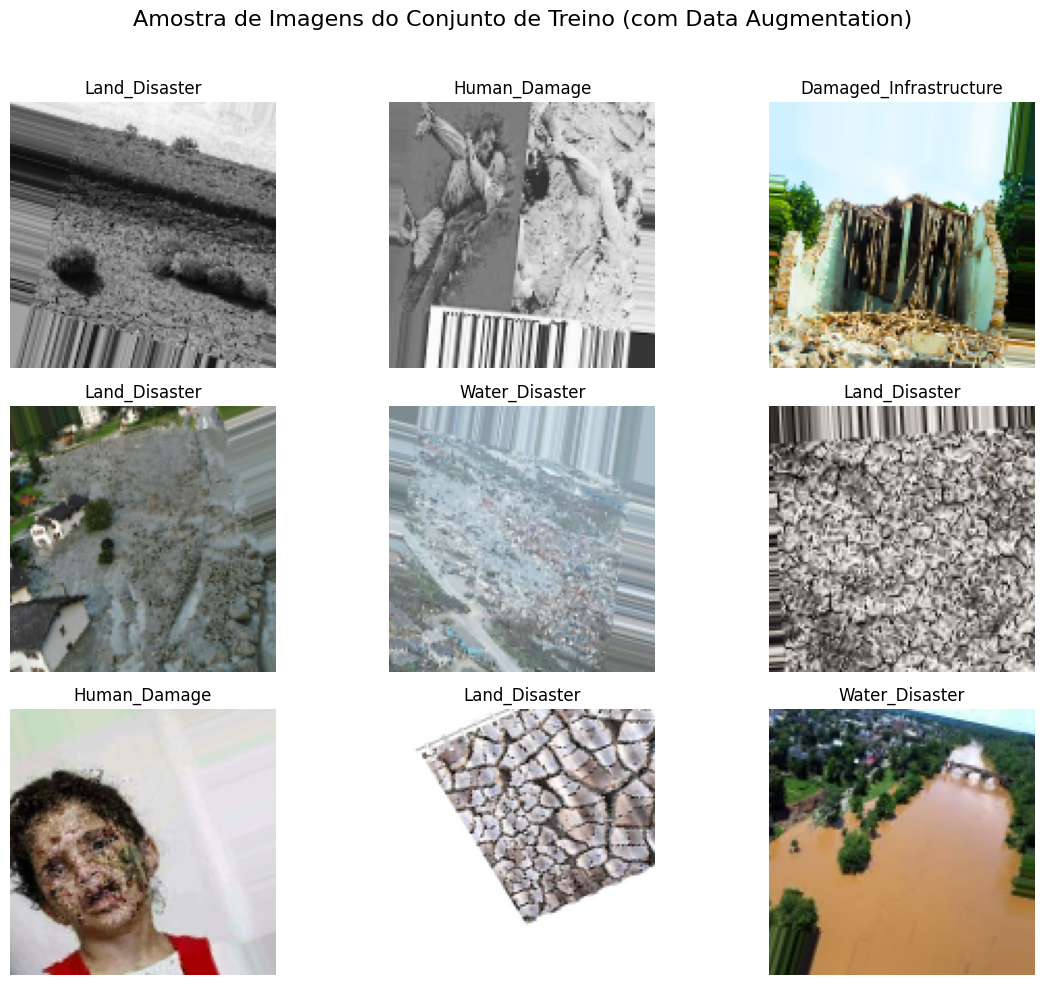

In [20]:

if train_generator:
    def plot_sample_images(data_generator):
        """Plota um grid de imagens de amostra do gerador."""
        sample_images, sample_labels = next(data_generator)
        plt.figure(figsize=(12, 10))
        class_names = list(data_generator.class_indices.keys())

        for i in range(min(9, len(sample_images))): # Mostra até 9 imagens
            plt.subplot(3, 3, i + 1)
            plt.imshow(sample_images[i])
            class_index = np.argmax(sample_labels[i])
            plt.title(class_names[class_index])
            plt.axis('off')
        plt.suptitle("Amostra de Imagens do Conjunto de Treino (com Data Augmentation)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    plot_sample_images(train_generator)
else:
    print("Gerador de treino não disponível. Não é possível mostrar imagens de amostra.")




# 5. Construção do Modelo de Rede Neural Convolucional (CNN)

Uma arquitetura CNN simples, ideal para começar.

### Componentes:

- `Conv2D`: Extrai características como bordas e texturas.
- `MaxPooling2D`: Reduz a dimensionalidade, mantendo informações importantes.
- `Flatten`: Transforma a saída 2D/3D em um vetor 1D.
- `Dense`: Camadas totalmente conectadas para classificação.
- `Dropout`: Regularização para prevenir overfitting, desativando aleatoriamente neurônios durante o treinamento.


In [21]:

model = None
if NUM_CLASSES > 0:
    model = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                      input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                      padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),

        layers.Dense(units=512, activation='relu'),
        layers.Dropout(0.5), # Dropout de 50%

        layers.Dense(units=NUM_CLASSES, activation='softmax') # Camada de saída
    ])

    print("\nArquitetura do Modelo:")
    model.summary() # Exibe um resumo da arquitetura do modelo
else:
    print("ERRO: NUM_CLASSES é zero. Modelo não pode ser construído.")
    print("Verifique os diretórios de treino e os caminhos.")



Arquitetura do Modelo:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,874,054 (64.37 MB)

 Trainable params: 16,874,054 (64.37 MB)

 Non-trainable params: 0 (0.00 B)


# 6. Compilação e Treinamento do Modelo

### Compilação

- **Otimizador (`optimizer`)**: `adam` é uma escolha popular e eficiente.
- **Função de Perda (`loss`)**: `categorical_crossentropy` para classificação multi-classe com *one-hot encoding*.
- **Métricas (`metrics`)**: `accuracy` é comum para tarefas de classificação.

### Callbacks

- `EarlyStopping`: Interrompe o treinamento se a performance não melhorar após certo número de épocas.
- `ModelCheckpoint`: Salva o modelo com a melhor performance em uma métrica.

### Treinamento com `model.fit`

- `train_generator`: Dados de treino.
- `epochs`: Número de épocas.
- `validation_data`: Dados de validação.
- `callbacks`: Lista de callbacks usados.


In [22]:

history = None # Para armazenar o histórico de treinamento

if model and train_generator and validation_generator:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("\nIniciando o treinamento do modelo...")

    # Definição dos callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        'best_disaster_classifier_model.keras', # Nome do arquivo para salvar o melhor modelo
        save_best_only=True,
        monitor='val_accuracy',
        mode='max', # Queremos maximizar a acurácia de validação
        verbose=1
    )

    # Treinamento do modelo
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint]
    )
    print("Treinamento concluído.")

    # Carregar os melhores pesos salvos pelo ModelCheckpoint
    if os.path.exists('best_disaster_classifier_model.keras'):
        print("Carregando o melhor modelo salvo ('best_disaster_classifier_model.keras').")
        model = keras.models.load_model('best_disaster_classifier_model.keras')
else:
    print("ERRO: Treinamento não pode ser iniciado. Verifique o modelo e os geradores de dados.")



Iniciando o treinamento do modelo...
Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2673 - loss: 2.0325
Epoch 1: val_accuracy improved from -inf to 0.26513, saving model to best_disaster_classifier_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.2681 - loss: 2.0272 - val_accuracy: 0.2651 - val_loss: 1.6898
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3673 - loss: 1.4899
Epoch 2: val_accuracy improved from 0.26513 to 0.27089, saving model to best_disaster_classifier_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.3681 - loss: 1.4888 - val_accuracy: 0.2709 - val_loss: 2.1861
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4768 - loss: 1.3376
Epoch 3: val_accuracy improved from 0.27089 to 0.35159, saving model to best_disaster_classifier_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4771 - loss: 1.3369 - val_accuracy: 0.3516 - val_loss: 1.9364
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2


# 7. Avaliação do Desempenho do Modelo

Após o treinamento, avaliamos o desempenho no conjunto de validação.

### Gráficos de Acurácia e Perda

- Mostram como a acurácia e a perda evoluíram nas épocas.
- Ajudam a identificar **overfitting** ou **underfitting**.

### Métricas

- `model.evaluate`: Avalia o modelo.
- **Matriz de Confusão**: Mostra erros de classificação por classe.
- **Relatório de Classificação (`classification_report`)**:
  - **Precisão (Precision)**: Correção das previsões de uma classe.
  - **Recall**: Cobertura das instâncias reais de uma classe.
  - **F1-Score**: Média harmônica entre precisão e recall.
  - **Support**: Número real de amostras por classe.



Avaliando o desempenho do modelo treinado...


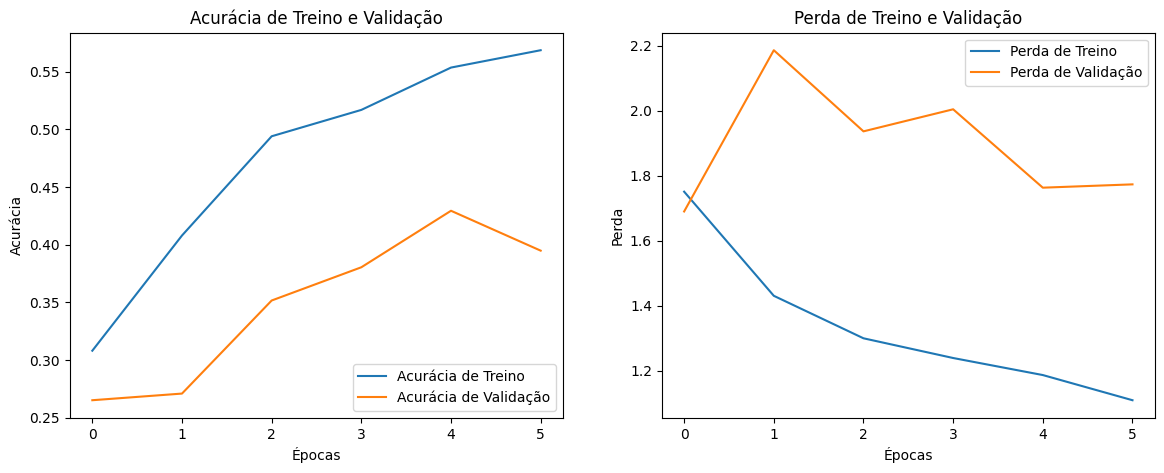


Performance final no conjunto de validação:
  Perda de Validação: 1.7630
  Acurácia de Validação: 42.94%
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 805ms/step


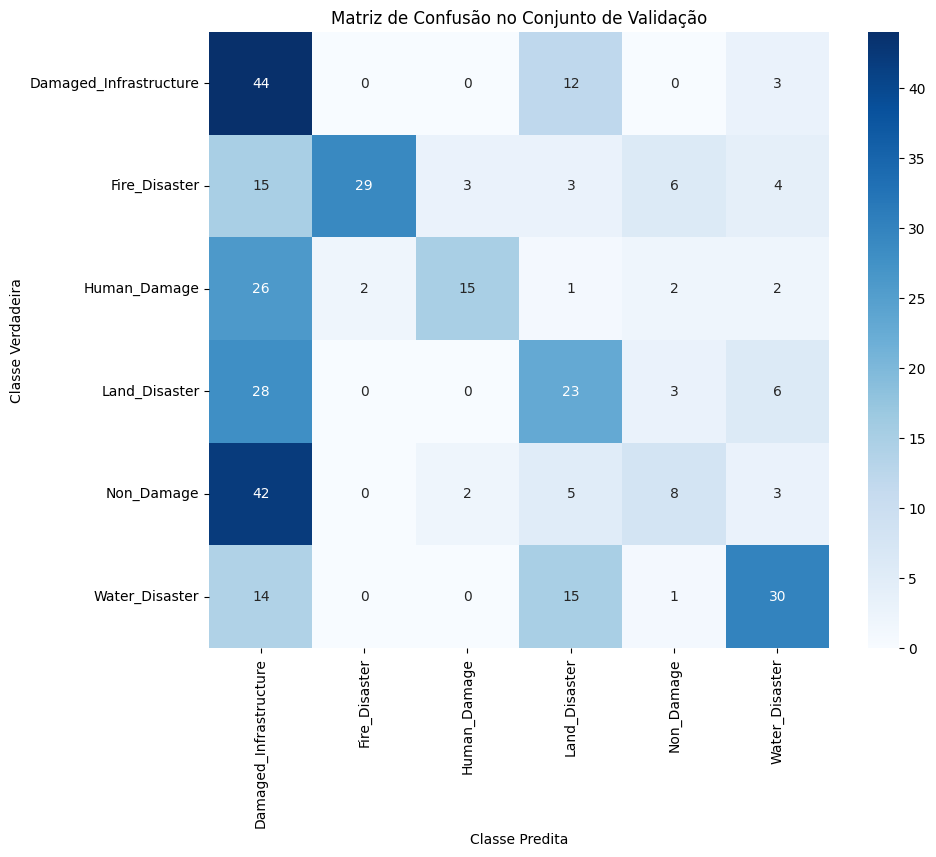


Relatório de Classificação no Conjunto de Validação:
                        precision    recall  f1-score   support

Damaged_Infrastructure       0.26      0.75      0.39        59
         Fire_Disaster       0.94      0.48      0.64        60
          Human_Damage       0.75      0.31      0.44        48
         Land_Disaster       0.39      0.38      0.39        60
            Non_Damage       0.40      0.13      0.20        60
        Water_Disaster       0.62      0.50      0.56        60

              accuracy                           0.43       347
             macro avg       0.56      0.43      0.43       347
          weighted avg       0.55      0.43      0.43       347



In [23]:

if history and model and validation_generator:
    print("\nAvaliando o desempenho do modelo treinado...")

    # Obter dados do histórico de treinamento
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    # Plotar gráficos
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    if acc and val_acc:
        plt.plot(epochs_range, acc, label='Acurácia de Treino')
        plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
        plt.legend(loc='lower right')
        plt.title('Acurácia de Treino e Validação')
    else:
        plt.title('Dados de Acurácia não disponíveis')
    plt.xlabel('Épocas'); plt.ylabel('Acurácia')

    plt.subplot(1, 2, 2)
    if loss and val_loss:
        plt.plot(epochs_range, loss, label='Perda de Treino')
        plt.plot(epochs_range, val_loss, label='Perda de Validação')
        plt.legend(loc='upper right')
        plt.title('Perda de Treino e Validação')
    else:
        plt.title('Dados de Perda não disponíveis')
    plt.xlabel('Épocas'); plt.ylabel('Perda')
    plt.show()

    # Avaliação final no conjunto de validação
    print("\nPerformance final no conjunto de validação:")
    try:
        loss_val, accuracy_val = model.evaluate(validation_generator, verbose=0)
        print(f"  Perda de Validação: {loss_val:.4f}")
        print(f"  Acurácia de Validação: {accuracy_val*100:.2f}%")

        # Predições para Matriz de Confusão e Relatório
        validation_generator.reset()
        Y_pred_probs = model.predict(validation_generator)
        y_pred_classes = np.argmax(Y_pred_probs, axis=1)
        y_true_classes = validation_generator.classes
        class_names = list(validation_generator.class_indices.keys())

        # Matriz de Confusão
        from sklearn.metrics import confusion_matrix, classification_report
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Matriz de Confusão no Conjunto de Validação')
        plt.ylabel('Classe Verdadeira'); plt.xlabel('Classe Predita')
        plt.show()

        # Relatório de Classificação
        print("\nRelatório de Classificação no Conjunto de Validação:")
        print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0))
    except Exception as e:
        print(f"Erro durante a avaliação no conjunto de validação: {e}")
else:
    print("Avaliação não pode ser realizada. Modelo não treinado ou dados de validação ausentes.")



# 8. Teste do Modelo com Novas Imagens (Exemplo)

Demonstra como usar o modelo treinado para prever uma nova imagem.

### Passos:

1. Carregar a imagem do disco.
2. Redimensionar para `IMAGE_SIZE`.
3. Converter para array NumPy.
4. Normalizar os pixels (dividir por `255.0`).
5. Expandir dimensões para formar um batch.
6. Usar `model.predict()` para prever.
7. Identificar a classe com maior probabilidade.



--- Testando o modelo treinado com uma imagem de exemplo ---
Usando imagem de exemplo para teste: 'meu_dataset_desastres/validation/Damaged_Infrastructure/05_01_0248.png'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


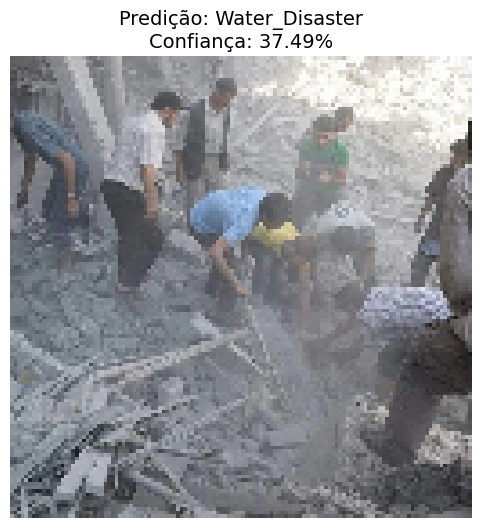

Imagem '05_01_0248.png' classificada como: Water_Disaster (Confiança: 37.49%)

--- Fim do Notebook ---


In [24]:

def predict_single_image(image_path, loaded_model, class_names_list):
    """Carrega, pré-processa, prevê e exibe uma única imagem."""
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array /= 255.0 # Normaliza
        img_array_expanded = tf.expand_dims(img_array, 0) # Cria um batch

        predictions = loaded_model.predict(img_array_expanded)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names_list[predicted_class_index]
        confidence = 100 * np.max(predictions[0])

        plt.figure(figsize=(6,6))
        plt.imshow(img) # Mostra a imagem original
        plt.title(f"Predição: {predicted_class_name}\nConfiança: {confidence:.2f}%", fontsize=14)
        plt.axis("off"); plt.show()
        print(f"Imagem '{os.path.basename(image_path)}' classificada como: {predicted_class_name} (Confiança: {confidence:.2f}%)")
        return predicted_class_name, confidence
    except FileNotFoundError:
        print(f"ERRO: Imagem não encontrada em '{image_path}'"); return None, None
    except Exception as e:
        print(f"ERRO ao processar imagem '{image_path}': {e}"); return None, None

# Testar com uma imagem de exemplo
if os.path.exists('best_disaster_classifier_model.keras') and validation_generator:
    print("\n--- Testando o modelo treinado com uma imagem de exemplo ---")
    loaded_model_for_testing = keras.models.load_model('best_disaster_classifier_model.keras')
    class_names_for_testing = list(validation_generator.class_indices.keys())

    example_image_path = None
    if os.path.exists(VALIDATION_DIR) and len(os.listdir(VALIDATION_DIR)) > 0:
        try:
            first_class_folder_name = os.listdir(VALIDATION_DIR)[0]
            first_class_path = os.path.join(VALIDATION_DIR, first_class_folder_name)
            if os.path.isdir(first_class_path) and len(os.listdir(first_class_path)) > 0:
                first_image_name = os.listdir(first_class_path)[0]
                example_image_path = os.path.join(first_class_path, first_image_name)
        except Exception as e:
            print(f"Não foi possível selecionar imagem de exemplo automaticamente: {e}")

    if example_image_path and os.path.exists(example_image_path):
        print(f"Usando imagem de exemplo para teste: '{example_image_path}'")
        predict_single_image(example_image_path, loaded_model_for_testing, class_names_for_testing)
    else:
        print("Não foi possível encontrar imagem de exemplo. Forneça o caminho manualmente.")
        # test_image_manual_path = 'caminho/para/sua/imagem.jpg' # DESCOMENTE E AJUSTE
        # if os.path.exists(test_image_manual_path):
        #   predict_single_image(test_image_manual_path, loaded_model_for_testing, class_names_for_testing)
else:
    print("\nModelo 'best_disaster_classifier_model.keras' ou gerador de validação não disponíveis.")
    print("Pule o teste ou treine o modelo primeiro.")

print("\n--- Fim do Notebook ---")